## LDA 3

# Fitting an LDA to our corpus

We plan to perform topic modeling using *Latent Dirichlet Allocation* (abbreviated as LDA). An LDA is a *generative model* that learns a group of categories (or *topics*) for words that occur together in a corpus of documents. For a technical presentation of LDAs, see [Appendix A](404).

Let's start loading up our corpus:

In [3]:
from utils.corpus import Corpus

corpus = Corpus(registry_path = 'utils/article_registry.json')

We instantiate an initial `Model` object and give it access to our corpus. We must also give it the number of topics it should train on.

In [4]:
from utils.model import Model

n_topics = 10
base_model = Model(corpus, n_topics)

Loading corpus. Num. of articles: 771


To train the `Model`, we can use the `train()` method. 

In [5]:
base_model.train()

Bags of words collected. Starting training...
Model trained! Creating Topic objects...


We can save this model to a file using the `save()` method:

In [4]:
base_model.save()

Saved to: gensim_models/gensim_10/yLDA_gensim_10


## Analyzing the Model Coherence

Coherence is an important statistic to compute in order to calibrate how many topics should we have on our final model. We can compute coherence by calling the `get_coherence()` method.

In [5]:
base_model.get_coherence()

0.3901658822280553

This coherence score allows us to do a search for the "best" `n_topics`. Let's print the coherence doing a normal search between 10 and 150 topics. Notice that this coherence score is sensitive to the random number generation that is used when creating the `lda`. If we wanted to control this randomness, we can pass a `seed` parameter to the `train()` method. We will do this later when we implement our final model.

In [6]:
coherence_per_topics = {}
for n_topics in range(10, 200, 10):
    coherences = []
    for _ in range(3):
        model = Model(corpus, n_topics)
        model.train()
        model_coherence = model.get_coherence()
        coherences.append(model_coherence)
        print(f'Topics: {n_topics}. Coherence Score: {model_coherence}')
    coherence_per_topics[n_topics] = coherences

Loading corpus. Num. of articles: 771
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Topics: 10. Coherence Score: 0.335999843591321
Loading corpus. Num. of articles: 771
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Topics: 10. Coherence Score: 0.3812417291690635
Loading corpus. Num. of articles: 771
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Topics: 10. Coherence Score: 0.41825009395521695
Loading corpus. Num. of articles: 771
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Topics: 20. Coherence Score: 0.36018794128071946
Loading corpus. Num. of articles: 771
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Topics: 20. Coherence Score: 0.37382284656077935
Loading corpus. Num. of articles: 771
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Topics: 

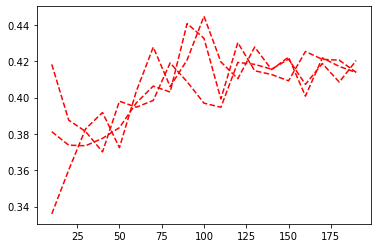

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x = list(coherence_per_topics.keys())
y = [coherence_per_topics[n] for n in x]

plt.plot(x, y, "--r")

As we can see, the coherence moves between 0.39 and 0.43. The optimal amount of topics seems to be upwards of 100 topics. However, we will run this same gridsearch, but storing more metadata about each model (such as: amount of documents per topic, and time it takes to train)

## Running a more complete grid-search

The last section shows we can compare different models and calibrate an optimal number of topics by training several models on a given number of topics. Now we will implement this experiment using a `gridsearch()` function. This function also makes use of the `get_stats()` method we included for each model.

TODO: Run it again after addressing this comment: https://github.com/RaRe-Technologies/gensim/issues/2115#issuecomment-443113360

In [8]:
def gridsearch(min_topics, max_topics, step, iterations=3, verbose=True):
    """
    Computes an array where we store statistics for each model. We run a search
    n number of times per number of topics and record a set of statistics for each model.
    At the end we will have n models per number of topics to compare.

    Returns an array of the following form:

    experiment = {
        n_topics: {
            0: [model(n_topics = 0).get_stats * iterations],
            1: [model(n_topics = 1).get_stats * iterations],
            ...
            iterations - 1: [model(n_topics = iterations - 1).get_stats()]
        }
    }
    
    We expect all these inner model_stats() to be slightly different
    due to stochasticity in the models.
    """
    
    experiment = {}
    for n_topics in range(min_topics, max_topics, step):
        experiment[n_topics] = {}
        print(f"\nRunning experiment for {n_topics} topics.")
        print("----------")
        for i in range(iterations):
            if verbose:
                print(f"Iteration: {i}")

            experiment[n_topics][i] = Model(corpus, n_topics).get_stats()

    return experiment

**Careful:** this gridsearch can take a whole evening.

In [9]:
experiment = gridsearch(80, 150, 10, iterations=3)


Running experiment for 80 topics.
----------
Iteration: 0
Loading corpus. Num. of articles: 771
Timing training...
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Getting model coherence...
Iteration: 1
Loading corpus. Num. of articles: 771
Timing training...
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Getting model coherence...
Iteration: 2
Loading corpus. Num. of articles: 771
Timing training...
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Getting model coherence...

Running experiment for 90 topics.
----------
Iteration: 0
Loading corpus. Num. of articles: 771
Timing training...
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Getting model coherence...
Iteration: 1
Loading corpus. Num. of articles: 771
Timing training...
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Getting model c

Finally, we can save it for further analysis later on:

In [10]:
import json

In [11]:
with open("../data/gridsearch.json", "w") as fp:
    json.dump(experiment, fp)

## Understanding the gridsearch results 

In [12]:
with open("../data/gridsearch.json") as fp:
    gridsearch = json.load(fp)

In [13]:
gridsearch

{'80': {'0': {'coherence': 0.4047119304989887,
   'log_perplexity': -12.062238247479334,
   'time_lda': 792.5756280422211,
   'time_coherence': 74.07882285118103,
   'orphans': 746,
   'avg_num_per_topic': 0.625,
   'std_num_per_topic': 0.899652710772329},
  '1': {'coherence': 0.4204455911034713,
   'log_perplexity': -12.021909924130577,
   'time_lda': 795.3768892288208,
   'time_coherence': 81.40315651893616,
   'orphans': 750,
   'avg_num_per_topic': 0.525,
   'std_num_per_topic': 0.7741931283601011},
  '2': {'coherence': 0.41608414859982046,
   'log_perplexity': -12.087465580926331,
   'time_lda': 818.9453876018524,
   'time_coherence': 83.9928331375122,
   'orphans': 744,
   'avg_num_per_topic': 0.675,
   'std_num_per_topic': 0.9971835337589566}},
 '90': {'0': {'coherence': 0.40884667322149826,
   'log_perplexity': -12.630776089306574,
   'time_lda': 964.1778750419617,
   'time_coherence': 86.45833325386047,
   'orphans': 741,
   'avg_num_per_topic': 0.6666666666666666,
   'std_num

In [14]:
def plotting(gridsearch):
    n_topics = np.array(list(gridsearch.keys())).astype(int)
    print(n_topics)
    coherences = []
    log_perplexities = []
    times_lda = []
    times_coherence = []
    
    for n in n_topics:
        iterations = gridsearch[str(n)]
        coherences.append(
            [v["coherence"] for v in iterations.values()]
        )
        log_perplexities.append(
            [v["log_perplexity"] for v in iterations.values()]
        )
        times_lda.append(
            [v["time_lda"] for v in iterations.values()]
        )
        times_coherence.append(
            [v["time_coherence"] for v in iterations.values()]
        )
        
    print(np.mean(coherences, axis=1))
    
    _, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0, 0].plot(n_topics, np.mean(coherences, axis=1))
    axes[0, 0].set_title("Coherence metric")
    
    axes[0, 1].plot(n_topics, np.mean(log_perplexities, axis=1))
    axes[0, 1].set_title("Log perplexity")

    axes[1, 0].plot(n_topics, np.mean(times_lda, axis=1))
    axes[1, 0].set_title("LDA training time")
    
    axes[1, 1].plot(n_topics, np.mean(times_coherence, axis=1))
    axes[1, 1].set_title("Coherence training time")

[ 80  90 100]
[0.41374722 0.41250581 0.41166851]


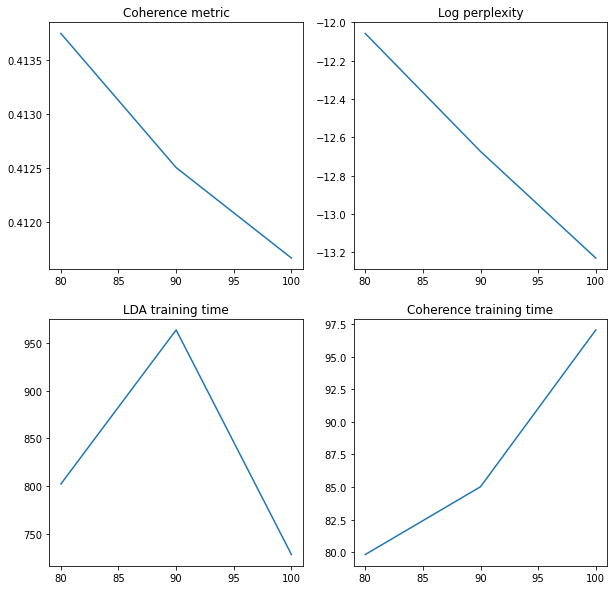

In [15]:
plotting(gridsearch)

# Optimal topics seems to be 90

Let's reload the gridsearch and study what happens around 90 topics

In [16]:
with open("../data/gridsearch.json") as fp:
    g = json.load(fp)

In [17]:
g["90"]

{'0': {'coherence': 0.40884667322149826,
  'log_perplexity': -12.630776089306574,
  'time_lda': 964.1778750419617,
  'time_coherence': 86.45833325386047,
  'orphans': 741,
  'avg_num_per_topic': 0.6666666666666666,
  'std_num_per_topic': 1.2018504251546633},
 '1': {'coherence': 0.43527518694706807,
  'log_perplexity': -12.729371389599105,
  'time_lda': 965.6527936458588,
  'time_coherence': 87.27617835998535,
  'orphans': 747,
  'avg_num_per_topic': 0.5333333333333333,
  'std_num_per_topic': 0.9568466729604883},
 '2': {'coherence': 0.3933955804897393,
  'log_perplexity': -12.660372093564968,
  'time_lda': 960.5202634334564,
  'time_coherence': 81.33149313926697,
  'orphans': 747,
  'avg_num_per_topic': 0.5333333333333333,
  'std_num_per_topic': 0.8844332774281066}}

In [18]:
for k in g:
    for v in g[k].values():
        if "-1" in v["n_articles_per_topic"]:
            print(f"Number of topics: {k}")
            print("Number of articles without 1st topic:")
            print(v["n_articles_per_topic"]["-1"])

KeyError: 'n_articles_per_topic'

From 100 onwards, 254 articles get systematically thrown to 0 topics. Weird!

90 doesn't have the no-topics-for-article problem, should we stick with it?

## Sticking with 90

After reading online, people recommend that we save our dictionary in order to prevent randomness in it in the future. I will also set up the seed for the LDA.

It has been 47,984 days since Wittgetstein was born (as of today, 09/09/20).

In [ ]:
final_model = Model(corpus, 90)
final_model.train(seed = 47984)
final_model.save()

Loading corpus. Num. of articles: 771
Bags of words collected. Starting training...
Model trained! Creating Topic objects...
Saved to: gensim_models/gensim_90/yLDA_gensim_90


In [ ]:
print(final_model.get_stats())